In [1]:
# # RUN THIS COMMAND ONLY IF YOU USE GOOGLE COLAB.
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/TechLabs/Predictive_Quality

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
df = pd.read_csv("Data/MiningProcess_Flotation_Plant_Database.csv", parse_dates = ['date'], decimal = ',')

In [4]:
df.set_index('date').astype(float)
pd.set_option("display.max_columns", 100)
df.head(3)

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31


In [5]:
hours = pd.Series(df['date'].unique()) 
hours.index = hours

In [6]:
# Creating date range from start to end
date_range = pd.date_range(start=df.iloc[0,0], end='2017-09-09 23:59:40', freq='20S')
# Removing certain indices due to lesser number of values captured this hour
date_range = date_range[6:]   


hours_list = hours.index.format()
seconds_list = date_range.format()

new_index = []

for idx in seconds_list:
    
    if (idx[:13]+':00:00') in hours_list:    # Checking if every time period is in the hours list of the original df
        new_index.append(idx)
        
new_index.remove('2017-04-10 00:00:00') # This hour has lesser values than the rest of the hours
        
df['index'] = new_index 
df['index'] = pd.to_datetime(df['index'])    # Converts to date time format
df.index = df['index']

df = df.drop(['index','date'], axis=1)
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
index,,,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:02:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:02:20,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:02:40,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:03:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,295.096,306.4,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
2017-03-10 01:03:20,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,295.096,306.4,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [7]:
# filt = (df['date'] >= '2017-06-01') & (df['date'] < '2017-06-15')
# df_filt = df.loc[filt]
# plt.scatter(df_filt['date'], df_filt['% Iron Feed'])

In [8]:
# # Trying to find correlation of output wrt input parameters
# plt.scatter(df['% Iron Feed'], df['% Iron Concentrate'], alpha=0.2)
# plt.show()

In [9]:
# # Plotting histogram plots
# names = df.columns.drop('datetime hours')
# ncols = len(names)
# fig, axes = plt.subplots(5,5, figsize=(15,12))
# for name, ax in zip(names, axes.flatten()):
#     sns.histplot(x=name, bins = 30, data=df, ax=ax)
    
# plt.tight_layout()

In [10]:
# # Plotting box plots
# fig, axes = plt.subplots(5,5, figsize=(15,12))
# for name, ax in zip(names, axes.flatten()):
#     sns.boxplot(y=name, data=df, orient='v', ax=ax)
    
# plt.tight_layout()

In [11]:
keep1 = [col for col in df.columns if 'Air Flow' in col]
flow_df = df.loc[:, keep1]

In [12]:
flow_df.columns = range(1,8)

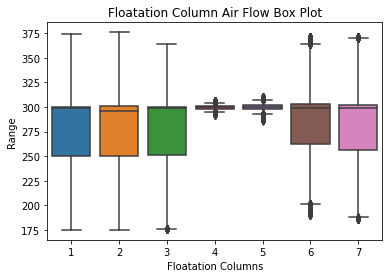

In [13]:
fig1 = sns.boxplot(data=flow_df, orient='v')
fig1.set(xlabel = "Floatation Columns", ylabel = "Range", title = "Floatation Column Air Flow Box Plot")
plt.show()

In [14]:
keep2 = [col for col in df.columns if 'Level' in col]
lvl_df = df.loc[:, keep2]

In [15]:
lvl_df.columns = range(1,8)

In [16]:
# fig2 = sns.boxplot(data=lvl_df, orient='v')
# fig2.set(xlabel = "Floatation Columns", ylabel = "Range", title = "Floatation Column Level Box Plot")
# plt.show()

In [17]:
# fig3 = sns.violinplot(data=lvl_df, orient='v') # Shows shape of parameter along with other stats
# fig3.set(xlabel = "Floatation Columns", ylabel = "Range", title = "Floatation Column Level Violin Plot")
# # fig3.Figure(figsize = (10,15))
# plt.show()

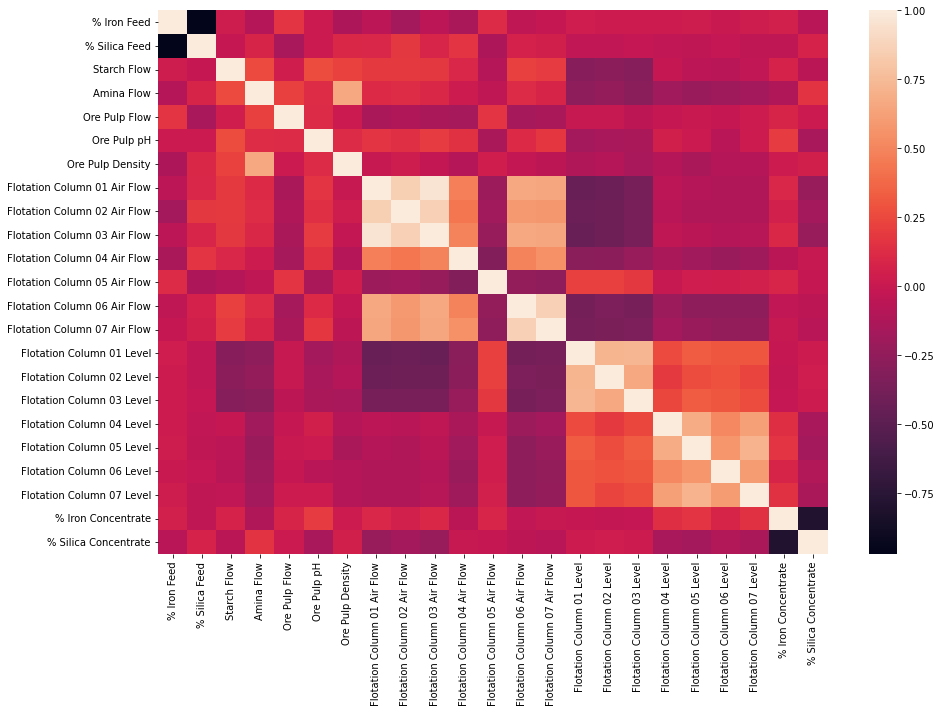

In [18]:
# Printing correlation between variables
corrMatrix = df.corr()

plt.figure(figsize = (15,10))
sns.heatmap(corrMatrix, annot = False)
plt.show()

In [19]:
# # Calculating the difference between 2 time values
# timedif = np.zeros(len(df["date"]) - 1)
# for i in range(len(df["date"])-1):
#     timedif[i] = (df['date'].iloc[i+1] - df['date'].iloc[i]).total_seconds()

In [20]:
# Not REQUIRED

# filt = (x != 0)
# y = x[filt]
# indexes, values = [i,j for i,j in enumerate(x) if j!=0]
# print(indexes, values)
# [print(x[i]) for i in range(len(x))]

In [21]:
# # Not REQUIRED
# # Keeping non zero values in timedif
# l = 0
# v=1
# delta = np.zeros([1000, 2]) # dynamic initialization
# for i,j in enumerate(timedif):
#     if j!=0:
#         delta[l, 0] = i
#         delta[l, 1] = j
#         l += 1
#         if l == v*1000:
#             delta = np.vstack([delta, np.zeros([1000, 2])])
#             v+=1

# # Trimming out the last zeros due to initializing
# filt = delta[:,1] != 0
# delta = delta[filt]
# # [print(j) for j in delta]

# # Interval change in the indices
# # [76493.  3600.]
# # [76672.  3600.]

In [22]:
# [print(i,j) for i,j in enumerate(x) if j!=0]

In [23]:
# # Outlier in time delta
# filt = delta[:, 1] != 3600
# out_time = delta[filt]
# out_time[0,1]/60

In [24]:
# names = newDF.columns.drop('datetime hours')
# ncols = len(names)
# fig, axes = plt.subplots(5,5, figsize=(15,12))
# for name, ax in zip(names, axes.flatten()):
#     sns.histplot(x=name, bins=30, data=newDF, ax=ax)
    
# plt.tight_layout()

In [25]:
# plt.figure(figsize=(15,6))
# plt.scatter(df.index, df['% Iron Feed'], alpha=0.2)
# plt.show()

In [26]:
sample = 'H'    # Sampling every hour
# sample = '30T'  # Sampling every 30 mins

In [27]:
hourly_df = df.resample(sample).mean()

In [28]:
# Filtering out data before 29th March (to remove large empty set)
filt1 = (hourly_df.index >= '2017-03-29 12:00:00')
hourly_df = hourly_df[filt1]

In [29]:
# Checking for nan values
# hourly_df.isna().sum()
hourly_df.isnull().values.any()

False

In [30]:
# Adding lags as a feature of Iron & Silica Concentrate
# Removing the first row since lag is nan

hourly_df["Iron_Lag"] = hourly_df['% Iron Concentrate'].shift(1)
hourly_df["Silica_Lag"] = hourly_df['% Silica Concentrate'].shift(1)

In [31]:
hourly_df.dropna(inplace = True)

In [32]:
hourly_df.head(3)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,Iron_Lag,Silica_Lag
index,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-29 13:00:00,60.18,9.34,2034.926525,322.233975,400.468947,9.700679,1.532017,199.990122,195.106250,199.765344,295.096,306.4,250.029056,250.059711,848.675503,777.784437,869.419421,483.816131,469.448172,471.607075,462.665478,66.57,1.43,66.44,1.36
2017-03-29 14:00:00,60.18,9.34,1435.425811,474.656322,399.157083,9.687788,1.645200,200.019311,195.604928,199.925800,295.096,306.4,249.979356,250.111328,851.951492,776.293654,879.704989,456.147231,453.227000,447.708467,453.475667,66.64,1.33,66.57,1.43
2017-03-29 15:00:00,60.18,9.34,618.460387,396.377733,398.942522,9.851689,1.559929,199.940833,195.657094,200.044339,295.096,306.4,249.978589,250.028506,855.910630,780.369869,882.093896,449.410744,448.581506,450.697578,448.660094,66.41,1.27,66.64,1.33


In [33]:
# Removing rows where Silica Concentrate does not change for more than 25 hours
buffer = "25H"
sunique = hourly_df.resample(buffer).nunique()["% Silica Concentrate"]

In [34]:
hourly_df[buffer] = np.nan

In [35]:
# Adding the buffer column
j = 0
for i in range(len(hourly_df)):
    if (hourly_df.index[i] == sunique.index[j+1]) & (hourly_df.index[i] != sunique.index[-1]):
        j = j+1
    elif (hourly_df.index[i] == sunique.index[-1]): # For the last index
        j = -1
    hourly_df.iloc[i, hourly_df.columns.get_loc(buffer)] = sunique.index[j]


In [36]:
# Cleaning interpolated values of % Silica Concentrate
filt1 = sunique == 1
extra_values = sunique[filt1].index
filt2 = ~hourly_df[buffer].isin(extra_values)
clean_df = hourly_df[filt2] 

In [37]:
clean_df = clean_df.drop(columns = buffer)

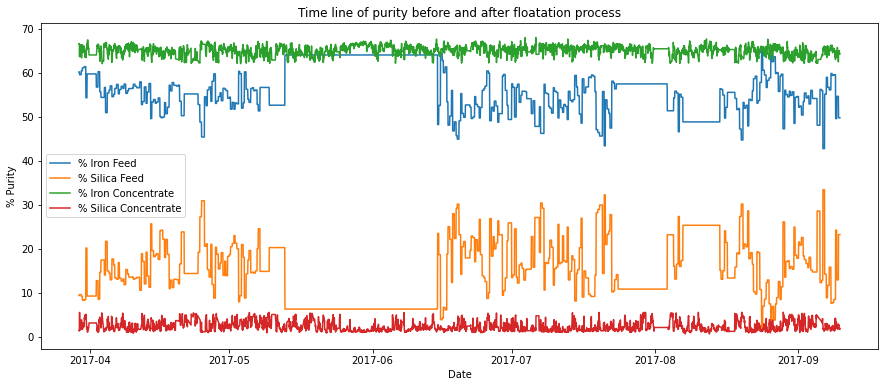

In [38]:
plt.figure(figsize=(15,6))
plt.plot(clean_df.index, '% Iron Feed', data=clean_df)
plt.plot(clean_df.index, '% Silica Feed', data=clean_df)
plt.plot(clean_df.index, '% Iron Concentrate', data=clean_df)
plt.plot(clean_df.index, '% Silica Concentrate', data=clean_df)
plt.title('Time line of purity before and after floatation process')
plt.ylabel('% Purity')
plt.xlabel('Date')
plt.legend()
plt.show()

In [39]:
# Normalization function
def scaling(arr):
    mini = arr.min()
    maxi = arr.max()
    scaled = pd.Series(index=arr.index, dtype=float)
    for i in range(len(arr)):
        scaled[i] = (arr[i] - mini)/(maxi - mini)
    svalue = scaled.values.reshape(-1,1)
    return (mini, maxi, svalue)

In [40]:
# Resclaling function
def rescale(mini, maxi, arr):
    rescaled = pd.Series(index=arr.index, dtype=float)
    for i in range(len(arr)):
        rescaled[i] = arr[i]*(maxi-mini) + mini
    resvalue = rescaled.values.reshape(-1,1)
    return resvalue

In [41]:
X_scaled_df = pd.DataFrame(index = clean_df.index)

In [42]:
# Scaling the data sets (Normalising)

col_list = clean_df.columns
mini_array = pd.Series(index = clean_df.columns, dtype = float)
maxi_array = pd.Series(index = clean_df.columns, dtype = float)

for i in range(len(col_list)):
    mini, maxi, X_scaled_df[f's_{col_list[i]}'] = scaling(clean_df[col_list[i]])
    mini_array.iloc[i] = mini
    maxi_array.iloc[i] = maxi

In [43]:
mini_array

% Iron Feed                      42.740000
% Silica Feed                     1.310000
Starch Flow                      54.595483
Amina Flow                      242.927477
Ore Pulp Flow                   376.837604
Ore Pulp pH                       8.753389
Ore Pulp Density                  1.519926
Flotation Column 01 Air Flow    176.047040
Flotation Column 02 Air Flow    178.188430
Flotation Column 03 Air Flow    177.202665
Flotation Column 04 Air Flow    293.336669
Flotation Column 05 Air Flow    287.056447
Flotation Column 06 Air Flow    196.512082
Flotation Column 07 Air Flow    199.728122
Flotation Column 01 Level       181.925623
Flotation Column 02 Level       224.909663
Flotation Column 03 Level       135.214506
Flotation Column 04 Level       165.725058
Flotation Column 05 Level       214.735894
Flotation Column 06 Level       203.702926
Flotation Column 07 Level       185.061388
% Iron Concentrate               62.050000
% Silica Concentrate              0.600000
Iron_Lag   

In [44]:
X_scaled_df.head(3)

,s_% Iron Feed,s_% Silica Feed,s_Starch Flow,s_Amina Flow,s_Ore Pulp Flow,s_Ore Pulp pH,s_Ore Pulp Density,s_Flotation Column 01 Air Flow,s_Flotation Column 02 Air Flow,s_Flotation Column 03 Air Flow,s_Flotation Column 04 Air Flow,s_Flotation Column 05 Air Flow,s_Flotation Column 06 Air Flow,s_Flotation Column 07 Air Flow,s_Flotation Column 01 Level,s_Flotation Column 02 Level,s_Flotation Column 03 Level,s_Flotation Column 04 Level,s_Flotation Column 05 Level,s_Flotation Column 06 Level,s_Flotation Column 07 Level,s_% Iron Concentrate,s_% Silica Concentrate,s_Iron_Lag,s_Silica_Lag
index,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-29 13:00:00,0.756944,0.250234,0.318608,0.160522,0.573122,0.461197,0.040537,0.175731,0.128458,0.181573,0.143501,0.969443,0.337717,0.332133,0.984715,0.917077,0.979428,0.623822,0.554527,0.541436,0.590094,0.758389,0.168357,0.736577,0.154158
2017-03-29 14:00:00,0.756944,0.250234,0.222157,0.469035,0.541306,0.454921,0.420008,0.175945,0.132244,0.182864,0.143501,0.969443,0.337403,0.332473,0.989553,0.914604,0.993149,0.569559,0.519213,0.493137,0.570560,0.770134,0.148073,0.758389,0.168357
2017-03-29 15:00:00,0.756944,0.250234,0.090718,0.310594,0.536103,0.534718,0.134119,0.175369,0.132640,0.183818,0.143501,0.969443,0.337398,0.331927,0.995400,0.921366,0.996336,0.556348,0.509099,0.499178,0.560323,0.731544,0.135903,0.770134,0.148073


In [45]:
X_scaled_df.shape

(3872, 25)

In [46]:
ratio = 0.2

In [47]:
id = round(ratio*len(X_scaled_df))

In [48]:
time_cut = X_scaled_df.index[id]

In [49]:
# Split the data into training/testing sets based on particular time
# time_cut = '2022-03-01 13:00:00'    # Half a day for testing
filt = X_scaled_df.index < time_cut

num = pd.Series(clean_df.index)
cut = num[num==time_cut].index[0]    # cut must be the index location pointing at the split (Required to plot)

X_test = X_scaled_df.loc[filt]
X_train = X_scaled_df.loc[~filt]

In [50]:
X_test.shape

(774, 25)

In [51]:
# Creating feature and target sets (arrays)
feature_pool = X_scaled_df.columns.values

remove_feature = ["s_% Iron Concentrate", "s_% Silica Concentrate", 's_Iron_Lag']

feature_col = []
[feature_col.append(x) for x in feature_pool if x not in remove_feature]
feature_col

['s_% Iron Feed',
 's_% Silica Feed',
 's_Starch Flow',
 's_Amina Flow',
 's_Ore Pulp Flow',
 's_Ore Pulp pH',
 's_Ore Pulp Density',
 's_Flotation Column 01 Air Flow',
 's_Flotation Column 02 Air Flow',
 's_Flotation Column 03 Air Flow',
 's_Flotation Column 04 Air Flow',
 's_Flotation Column 05 Air Flow',
 's_Flotation Column 06 Air Flow',
 's_Flotation Column 07 Air Flow',
 's_Flotation Column 01 Level',
 's_Flotation Column 02 Level',
 's_Flotation Column 03 Level',
 's_Flotation Column 04 Level',
 's_Flotation Column 05 Level',
 's_Flotation Column 06 Level',
 's_Flotation Column 07 Level',
 's_Silica_Lag']

In [52]:
X_trainarray = X_train[feature_col].values      # Feature columns
# Y_trainarray = np.ravel(X_train["s_% Silica Concentrate"].values)   # ravel used to make 1D array, reshape makes column array
Y_trainarray = X_train["s_% Silica Concentrate"].values.reshape(-1,1)

X_testarray = X_test[feature_col].values
# Y_testarray = np.ravel(X_test["s_% Silica Concentrate"].values)    # ravel used to make 1D array, reshape makes column array
Y_testarray = X_test["s_% Silica Concentrate"].values.reshape(-1,1)

In [53]:
print(Y_trainarray.shape, X_trainarray.shape)

(3098, 1) (3098, 22)


In [54]:
# Input for LSTM requires data to be of 3D shape
trainX = np.reshape(X_trainarray, (X_trainarray.shape[0],1,X_trainarray.shape[1]))
testX = np.reshape(X_testarray, (X_testarray.shape[0],1,X_testarray.shape[1]))

In [55]:
model = Sequential()    # from Tensorflow

In [56]:
# LSTM Model
units = 30
model.add(LSTM(units,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2]),kernel_initializer='lecun_uniform'))
model.add(Dropout(0.2))    # Dropping 20% of data for the next training
model.add(LSTM(units, return_sequences=True))
model.add(Dropout(0.2))    
model.add(LSTM(units))
model.add(Dropout(0.2))
model.add(Dense(1))         # One output node      
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.fit(trainX, Y_trainarray, batch_size=120, epochs=100, validation_data=(testX, Y_testarray), verbose=0)

In [57]:
Y_pred_scaled = model.predict(testX)

25/25 [==============================] - 1s 2ms/step


In [58]:
Y_pred_scaled.shape

(774, 1)

In [59]:
# Mean Squared Error (MSE) & Variance Score (R2): R2 = 1 is perfect prediction
print("Mean squared error: %.2f" % mean_squared_error(Y_testarray, Y_pred_scaled))
print('R2 score: %.2f' % r2_score(Y_testarray, Y_pred_scaled))

Mean squared error: 0.02
R2 score: 0.56


In [60]:
# Rescaling back to Non-normalised values

indi = X_test.index   # Specify the right index
parameter = "% Silica Concentrate"   # Specify the right parameter

Y_pred_scaled_series = pd.Series(np.ravel(Y_pred_scaled), index = indi)  
Y_prediction = rescale(mini_array.loc[parameter], maxi_array.loc[parameter], Y_pred_scaled_series)

In [61]:
Y_prediction.shape

(774, 1)

In [62]:
Yindi = clean_df.columns.get_loc('% Silica Concentrate')

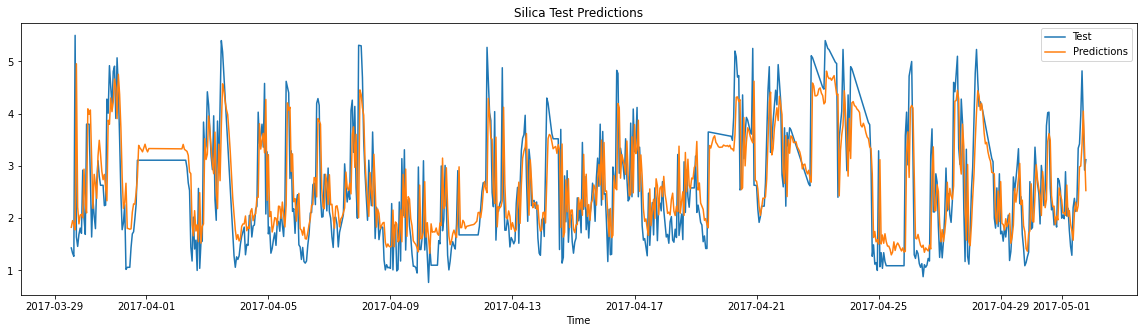

In [63]:
# Plotting Temperature prediction
plt.figure(figsize=(20,5))
plt.plot(indi, clean_df.iloc[:cut, Yindi].values)
plt.plot(indi, Y_prediction)
plt.legend(['Test', 'Predictions'])
plt.title("Silica Test Predictions")
plt.xlabel("Time")
plt.savefig(fname = 'Images\LSTM_predictions.jpg')
plt.show()